<a href="https://colab.research.google.com/github/TiGaI/HousingPriceKaggleProject3/blob/xiangwei/ames_edaNEW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
### import necessary packages
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib as plt
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

#Add max display column
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [0]:
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats.stats import pearsonr

**Jupyterhub sux**


---



In [0]:
### load training and test data
train = pd.read_csv('https://raw.githubusercontent.com/TiGaI/HousingPriceKaggleProject3/master/data/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/TiGaI/HousingPriceKaggleProject3/master/data/test.csv')
# interest_df = pd.read_csv('https://raw.githubusercontent.com/TiGaI/HousingPriceKaggleProject3/xiangwei/data/interest.csv')
# ameshpi = pd.read_csv('https://raw.githubusercontent.com/TiGaI/HousingPriceKaggleProject3/xiangwei/data/ameshpi.csv')
# sch_rank = pd.read_csv('https://raw.githubusercontent.com/TiGaI/HousingPriceKaggleProject3/xiangwei/data/SchoolRanking.csv')


### view train dataset
# train_df.head()
#print(test_df.shape)
#print(train_df.shape)

In [0]:
#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

# From EDA obvious outliers
train = train[train.GrLivArea < 4500]
train.reset_index(drop=True, inplace=True)

outliers = [30, 88, 462, 631, 1322]
train = train.drop(train.index[outliers])

# Apply transformation
train.SalePrice = np.log1p(train.SalePrice )
# New prediction
y_train = train.SalePrice.values
y_train_orig = train.SalePrice

train.drop("SalePrice", axis=1, inplace=True)

data_features = pd.concat((train, test)).reset_index(drop=True)


In [0]:
def ImputeMissingValue(df):
  str_vars = ['MSSubClass','YrSold','MoSold']
  for var in str_vars:
      df[var] = df[var].apply(str)

  # 'RL' is by far the most common value. So we can fill in missing values with 'RL'
  df['MSZoning'] = df.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

  for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual',
          'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',"PoolQC"
         ,'Alley','Fence','MiscFeature','FireplaceQu','MasVnrType','Utilities']:df[col] = df[col].fillna('None')

  for col in ('GarageYrBlt', 'GarageArea', 'GarageCars','MasVnrArea','BsmtFinSF1','BsmtFinSF2'
         ,'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BsmtUnfSF','TotalBsmtSF'):
      df[col] = df[col].fillna(0)

  df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

  df['Functional'] = df['Functional'].fillna('Typ')

  return df

def Normalize(df, lam):
  '''
  this function will normalize the numeric variables including the ordinal variables with mean of 0 and variance of 1
  '''
  idx_num = df.dtypes[df.dtypes != "object"].index

  # Check how skewed they are
  skew_num = df[idx_num].apply(lambda x: stats.skew(x.dropna())).sort_values(ascending=False)
  skewness = skew_num[abs(skew_num) > 0.5]

  df_full = df.copy()
  for feat in skewness.index:
    df_full[feat] = boxcox1p(df_full[feat], 0.15)

  return df_full

def FeatureEngineering(df):
  #  Adding total sqfootage feature 
  df['TotalSF']=df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
  #  Adding total bathrooms feature
  df['Total_Bathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) +
                              df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))
  #  Adding total porch sqfootage feature
  df['Total_porch_sf'] = (df['OpenPorchSF'] + df['3SsnPorch'] +
                              df['EnclosedPorch'] + df['ScreenPorch'] +
                              df['WoodDeckSF'])
  df['haspool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
  df['hasgarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
  df['hasbsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
  df['hasfireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)


  # Not normaly distributed can not be normalised and has no central tendecy
  df = df.drop(['MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', 'BsmtFinSF1','2ndFlrSF'], axis=1)

  return df


In [12]:
ImputeMissingValue(data_features)
FeatureEngineering(data_features)
Normalize(data_features, 0.15)

NameError: ignored

In [13]:
final_features = pd.get_dummies(data_features)
print(final_features.shape)

(2912, 339)


NameError: ignored

In [14]:
X = final_features.iloc[:len(y_train), :]
X_test = final_features.iloc[len(y_train):, :]
X.shape, y_train.shape, X_test.shape


print(X.shape,y_train.shape,X_test.shape)

# Removes colums where the threshold of zero's is (> 99.95), means has only zero values 
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.95:
        overfit.append(i)

overfit = list(overfit)
overfit.append('MSZoning_C (all)')

X = X.drop(overfit, axis=1).copy()
X_test = X_test.drop(overfit, axis=1).copy()

print(X.shape,y_train.shape,X_test.shape)

(1453, 339) (1453,) (1459, 339)
(1453, 336) (1453,) (1459, 336)


In [0]:
#### study the missing values
train_missing = train_df.isna()
train_num_missing = train_missing.sum().to_frame()
#train_num_missing.sort_values(ascending = False)
train_num_missing['Percentage'] = train_num_missing[0]/1460
train_num_missing.columns = ['Missing Value', 'Percentage']
train_num_missing = train_num_missing.sort_values('Percentage', ascending = False)
train_num_missing[train_num_missing['Missing Value'] > 0]  ### 19

,Missing Value,Percentage
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


***Treating Missing Value ***

In [0]:
### Treating the missing values
train_full = train_df.drop('Id', axis = 1)
print(train_full.columns)

## 'LotFrontage', 'MasVnrArea', 'PoolArea'
#num columns we filling in missing value with zero
train_full['LotFrontage'].fillna(0, inplace=True)  ## fill in the NAs of LotFrontage with 0
train_full['MasVnrArea'].fillna(0, inplace=True)  ## fill in the NAs of MasVnrArea with 0
train_full['Pool'] = train_full['PoolArea'].apply(lambda x: 1 if x > 0 else 0)  ## create a new variable indicating whether the house has a pool or not

## 'MasVnrType', 'PoolQC', 'GarageCond'
#cat columns
train_full['MasVnrType'].fillna('None', inplace=True)  ## fill in the NAs of MasVnrType with None
train_full['PoolQC'].fillna('None',inplace=True)  ## fill in the NAs of PoolQC with None

## Hash 'PoolQC'
PoolReplacement = {
   'PoolQC': {
      'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5
   }
}

# replace the PoolQC
train_full.replace(PoolReplacement, inplace=True)

## Hash 'GarageQual', 'GarageCond', 'GarageFinish'
garabgeReplacement = {
   'GarageQual': {
      np.nan:0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5
   },
    'GarageCond': {
      np.nan:0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5
   },
    'GarageFinish': {
      np.nan:0, 'Unf': 1, 'RFn': 2, 'Fin': 3
   }
}

# replace 'GarageQual', 'GarageCond', 'GarageFinish'
train_full = train_full.replace(garabgeReplacement, inplace=False)

# create 'GarageQuality' that takes the average of 'GarageQual' and 'GarageCond'
train_full["GarageQuality"] = (train_full["GarageQual"] + train_full["GarageCond"])/2

# fill in the NAs of GarageYrBlt with YearBuilt
train_full['GarageYrBlt'].fillna(train_full['YearBuilt'], inplace=True)

# fill in the NAs of 'GarageType' with 'None'
train_full['GarageType'].fillna("None", inplace=True)

## Hash 'BsmtFinType1', 'BsmtFinType2', 'BsmtExposure', 'BsmtCond', 'BsmtQual'
BsmtReplacement = {
   'BsmtFinType1': {
      np.nan:0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6
   },
    'BsmtFinType2': {
      np.nan:0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6
   },
    'BsmtExposure': {
        np.nan:0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4
    },
    'BsmtCond': {
        np.nan:0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5
    },
    'BsmtQual': {
        np.nan:0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5
    },
}

# replace 'BsmtFinType1', 'BsmtFinType2', 'BsmtExposure', 'BsmtCond', 'BsmtQual'
train_full = train_full.replace(BsmtReplacement)

# convert the type of 'BsmtCond' to int64
train_full["BsmtCond"] = train_full["BsmtCond"].astype(np.int64)

## Hash FireplaceQu
FirePlaceReplacement ={
    'FireplaceQu': {
        np.nan: 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5
    }
}

# replace 'FireplaceQu'
train_full = train_full.replace(FirePlaceReplacement)

### replace the conditions and qualities with numbers: 'ExterQual', 'ExterCond, 'HeatingQC', 'KitchenQual', 'CentralAir', 'LotShape'
CondReplacement = {
   'ExterQual': {
      'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5
   },
    'ExterCond': {
      'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5
   },
    'HeatingQC': {
        'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5
    },
    'KitchenQual': {
        'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5
    },
    'CentralAir': {
        'N': 0, 'Y': 1
    },
    'LotShape': {
        'IR3': 0, 'IR2': 1, 'IR1': 2, 'Reg': 3
    },
    'Functional': {
        'Typ': 5, 'Min1': 4, 'Min2': 4, 'Mod': 3, 'Maj1': 2, 'Maj2': 2, 'Sev': 1, 'Sal': 0
    },
    'LandSlope': {
        'Gtl': 0, 'Mod': 1, 'Sev': 2
    }
}

# replace those variables
train_full = train_full.replace(CondReplacement)


## Fill the NAs of 'Electrical' with 'SBrkr'
train_full['Electrical'].fillna('SBrkr', inplace=True)

## Fill the NAs of 'Fence' with 'None'
train_full['Fence'].fillna('None', inplace=True)

## Alley? Drop Alley?
train_full = train_full.drop(['Alley'], axis=1)

## Fill the NAs of 'MiscFeature' with None
train_full['MiscFeature'].fillna('None', inplace=True)

#### study the missing values
train_missing = train_full.isna()
train_num_missing = train_missing.sum().to_frame()
#train_num_missing.sort_values(ascending = False)
train_num_missing['Percentage'] = train_num_missing[0]/1460
train_num_missing.columns = ['Missing Value', 'Percentage']
train_num_missing = train_num_missing.sort_values('Percentage', ascending = False)
train_num_missing  ### 19

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

,Missing Value,Percentage
MSSubClass,0,0.0
1stFlrSF,0,0.0
GarageCars,0,0.0
GarageFinish,0,0.0
GarageYrBlt,0,0.0
GarageType,0,0.0
FireplaceQu,0,0.0
Fireplaces,0,0.0
Functional,0,0.0
TotRmsAbvGrd,0,0.0


*** Feature Engineereing ***

In [0]:
### find the age of the house by subtracting YrSold and YearRemodAdd
train_full['HouseAge'] = train_full['YrSold']-train_full['YearRemodAdd']

### find the age of the garage by subtracting YrSold and GarageYrBlt
train_full['GarageAge'] = train_full['YrSold'] - train_full['GarageYrBlt']   ### this has 0.6 correlation with HouseAge

### create a binary remodel variable to denote whether it has been remodeled or not
train_full['Remodel'] = (
    np.where(
        train_full['YearBuilt'] == train_full['YrSold'], 
        0, 
        1
        ))

### create a new variable TotolBath to sum up the num of bathrooms in the house
train_full['TotalBath'] = train_full['FullBath'] + 0.5 * train_full['HalfBath'] + train_full['BsmtFullBath'] + 0.5 * train_full['BsmtHalfBath']

### create a new variable WtTotalBsmtSF
def WeightedBasement(x):
  if x['BsmtFinType1'] == 1:
    return x['TotalBsmtSF'] 
  else:
    if x['BsmtFinType2'] != 1:
      return (x['BsmtFinType1'] * x['BsmtFinSF1'] + x['BsmtFinType2'] * x['BsmtFinSF2'])
    else:
      return (x['BsmtFinType1'] * x['BsmtFinSF1'] + x['BsmtUnfSF'])
  
train_full['WeightTotalBsmtSF'] = train_full.apply (lambda row: WeightedBasement(row), axis=1)

### Take care of PorchSF 
train_full['TotalPorchSF'] = train_full['OpenPorchSF'] + train_full['EnclosedPorch'] + train_full['3SsnPorch'] + train_full['ScreenPorch']

## replace the MSZoning by Mean and median
MSZoninglReplacement = {
   'MSZoning': {
      'C (all)': 0, 'RM': 1, 'RH': 2, 'RL': 3, 'FV': 4
   }
}

# replace the MSZoning
train_full.replace(MSZoninglReplacement, inplace=True)

#a=train_full.groupby(['Condition1']).agg({'SalePrice':['mean', 'median']}).reset_index()
#b=train_full.groupby(['Condition2']).agg({'SalePrice':['mean', 'median']}).reset_index()
#print(a)
#print(b)

## Take care of Condition1 and Condition 2
train_full['Condition2Renew'] = np.where(train_full['Condition1'] == train_full['Condition2'], 0, 1)
train_full = train_full.drop(['Condition2'], axis=1)

#### collapse 'MSSubClass', 'HouseStyle' into 'Floor', 'Finished', 'PUD', 'SFoyer', 'SLvl', 
## Create 'PUB' column:
def PUDCol(x):
  if x['MSSubClass'] in [120,150,160,180]:
    return 1
  else:
    return 0
  
train_full['PUD'] = train_full.apply (lambda row: PUDCol(row), axis=1)

## collapse 'HouseStyle' into 'SFoyer', 'Floor', 'Finish', 'Slvl'
tempstyle = train_full['HouseStyle'].str.split('(\d*\.\d+|\d+)([A-Za-z]+)', expand=True)
tempstyle.rename(columns={0:'SFoyer',1:'Floor', 2:'Finish',3:'Slvl'}, inplace=True)
tempstyle['Slvl'] = np.where(tempstyle['SFoyer']=="Slvl", 1, 0)
tempstyle['SFoyer'] = np.where(tempstyle['SFoyer']=="SFoyer", 1, 0)
tempstyle['Finish'] = np.where(tempstyle['Finish']=="Story", 1, tempstyle['Finish'])
tempstyle['Finish'] = np.where(tempstyle['Finish']=="Fin", 1, tempstyle['Finish'])
tempstyle['Finish'] = np.where(tempstyle['Finish']=="Unf", 0, tempstyle['Finish'])
#tempstyle
train_full1 = pd.concat([train_full, tempstyle], axis = 1)


## fill in the blanks for Floor
def FloorCol(df):
  if df['HouseStyle'] == 'SFoyer':
    if df['MSSubClass'] == 85:
      return 1.5
    if df['MSSubClass'] == 90:
      return 1.5
    if df['MSSubClass'] == 180:
      return 2.5
    if df['MSSubClass'] == 120:
      return 1
  elif df['HouseStyle'] == 'SLvl':
    if df['MSSubClass'] == 80:
      return 1.5
    if df['MSSubClass'] == 180:
      return 2.5
    if df['MSSubClass'] == 190:
      return 2.5
    if df['MSSubClass'] == 20:
      return 1
    if df['MSSubClass'] == 90:
      return 2
    if df['MSSubClass'] == 60:
      return 2
  else:
    return df['Floor']

train_full1['Floor'] = train_full1.apply (lambda row: FloorCol(row), axis=1)
train_full1['Floor'] = train_full1['Floor'].astype(np.float16)

### fill in the blanks for Finish
train_full1['Finish'].fillna(1, inplace=True)

### Fill in the exterior
train_full1['exterior1stC'], _ = pd.factorize(train_full1['Exterior1st'], sort=True)
train_full1['exterior2ndC'], _ = pd.factorize(train_full1['Exterior2nd'], sort=True)
#print(train_full1['exterior2ndC'].corr(train_full1['exterior1stC']))  0.8541629837325749

train_full2 = train_full1.groupby('exterior1stC').agg({'SalePrice': 'mean'})
train_full2 = train_full2.reset_index()
train_full2 = pd.qcut(train_full2['SalePrice'], 4, labels=[0.25,0.5,0.75,1])
train_full1['ExteriorBin'] = train_full1['exterior1stC'].apply(lambda x: train_full2[x])
#train_full1['ExteriorBin'].value_counts()

#### study the missing values
train_missing = train_full1.isna()
train_num_missing = train_missing.sum().to_frame()
#train_num_missing.sort_values(ascending = False)
train_num_missing['Percentage'] = train_num_missing[0]/1460
train_num_missing.columns = ['Missing Value', 'Percentage']
train_num_missing = train_num_missing.sort_values('Percentage', ascending = False)
train_num_missing

,Missing Value,Percentage
MSSubClass,0,0.0
GarageQual,0,0.0
PoolQC,0,0.0
PoolArea,0,0.0
ScreenPorch,0,0.0
3SsnPorch,0,0.0
EnclosedPorch,0,0.0
OpenPorchSF,0,0.0
WoodDeckSF,0,0.0
PavedDrive,0,0.0


In [0]:
train_full1.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF

In [0]:
### Variables to drop
train_full1.drop(['YearBuilt', 'YearRemodAdd', 'Exterior1st', 'Exterior2nd', 'exterior1stC', 'exterior2ndC','HouseStyle', 'MSSubClass', 'YearBuilt', 'YearRemodAdd', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch','BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'GarageCond', 'GarageQual', 'GarageYrBlt'], axis=1, inplace = True)

In [0]:
train_full1['Functional'].value_counts()

5    1360
4      65
2      19
3      15
1       1
Name: Functional, dtype: int64

In [0]:
train_full1.head()
#train_full1.columns.shape

,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,OverallQual,OverallCond,RoofStyle,RoofMatl,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,PavedDrive,WoodDeckSF,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Pool,GarageQuality,HouseAge,GarageAge,Remodel,TotalBath,WeightTotalBsmtSF,TotalPorchSF,Condition2Renew,PUD,SFoyer,Floor,Finish,Slvl,ExteriorBin
0,3,65.0,8450,Pave,3,Lvl,AllPub,Inside,0,CollgCr,Norm,1Fam,7,5,Gable,CompShg,BrkFace,196.0,4,3,PConc,4,3,1,6,706,1,0,150,856,GasA,5,1,SBrkr,856,854,0,1710,3,1,4,8,5,0,0,Attchd,2,2,548,Y,0,0,0,None,None,0,2,2008,WD,Normal,208500,0,3.0,5,5.0,1,3.5,4386,61,0,0,0,2.0,1,0,1.0
1,3,80.0,9600,Pave,3,Lvl,AllPub,FR2,0,Veenker,Feedr,1Fam,6,8,Gable,CompShg,None,0.0,3,3,CBlock,4,3,4,5,978,1,0,284,1262,GasA,5,1,SBrkr,1262,0,0,1262,3,1,3,6,5,1,3,Attchd,2,2,460,Y,298,0,0,None,None,0,5,2007,WD,Normal,181500,0,3.0,31,31.0,1,2.5,5174,0,1,0,0,1.0,1,0,0.5
2,3,68.0,11250,Pave,2,Lvl,AllPub,Inside,0,CollgCr,Norm,1Fam,7,5,Gable,CompShg,BrkFace,162.0,4,3,PConc,4,3,2,6,486,1,0,434,920,GasA,5,1,SBrkr,920,866,0,1786,3,1,4,6,5,1,3,Attchd,2,2,608,Y,0,0,0,None,None,0,9,2008,WD,Normal,223500,0,3.0,6,7.0,1,3.5,3350,42,0,0,0,2.0,1,0,1.0
3,3,60.0,9550,Pave,2,Lvl,AllPub,Corner,0,Crawfor,Norm,1Fam,7,5,Gable,CompShg,None,0.0,3,3,BrkTil,3,4,1,5,216,1,0,540,756,GasA,4,1,SBrkr,961,756,0,1717,3,1,4,7,5,1,4,Detchd,1,3,642,Y,0,0,0,None,None,0,2,2006,WD,Abnorml,140000,0,3.0,36,8.0,1,2.0,1620,307,0,0,0,2.0,1,0,0.5
4,3,84.0,14260,Pave,2,Lvl,AllPub,FR2,0,NoRidge,Norm,1Fam,8,5,Gable,CompShg,BrkFace,350.0,4,3,PConc,4,3,3,6,655,1,0,490,1145,GasA,5,1,SBrkr,1145,1053,0,2198,4,1,4,9,5,1,3,Attchd,2,3,836,Y,192,0,0,None,None,0,12,2008,WD,Normal,250000,0,3.0,8,8.0,1,3.5,4420,84,0,0,0,2.0,1,0,1.0


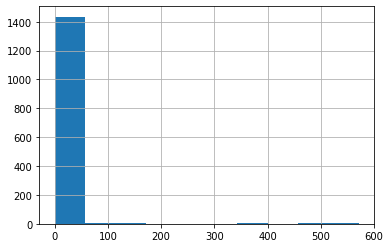

In [0]:
train_full1['LowQualFinSF'].hist()

In [0]:
#string_cols = [col for col in train_full1.columns if 'string' in col]
#String_cols
#print(train_full1.columns)
train_full1.columns.difference(train_df.columns)

Index(['Condition2Renew', 'ExteriorBin', 'Finish', 'Floor', 'GarageAge',
       'GarageQuality', 'HouseAge', 'PUD', 'Pool', 'Remodel', 'SFoyer', 'Slvl',
       'TotalBath', 'TotalPorchSF', 'WeightTotalBsmtSF'],
      dtype='object')

In [0]:
train_full1[train_full1['BsmtFinType1'] == 1]['BsmtUnfSF']

8        952
13      1494
15       832
20      1158
21       637
22      1777
25      1566
29       520
30       649
31      1228
32      1234
35      1117
36      1097
48       736
51       816
57       860
58      1410
61       530
63       576
65      1143
68       747
72       832
74       840
78      1768
79       440
83      1065
84       384
85      1288
86       684
87       612
88      1013
101      741
103     1226
105     1053
106      641
108      793
117     1125
119      728
121      732
124     1362
135     1304
137     1907
145      970
147      884
149      896
154     1200
155      572
157      774
163      882
168      840
169     1686
179      968
183     1362
184      504
185     1107
187      660
193      970
198      755
200     1121
205     1424
206     1140
217      686
220     1498
221     1010
225      630
230     1194
232      483
238     1694
242      540
243      626
246     1020
247     1367
248      840
250      728
252      798
255      975
261     1482

In [0]:
train_full1.corr()['SalePrice'].sort_values(ascending=False)

SalePrice            1.000000
OverallQual          0.790982
GrLivArea            0.708624
ExterQual            0.682639
KitchenQual          0.659600
GarageCars           0.640409
TotalBath            0.631731
GarageArea           0.623431
TotalBsmtSF          0.613581
1stFlrSF             0.605852
BsmtQual             0.585207
GarageFinish         0.549247
TotRmsAbvGrd         0.533723
WeightTotalBsmtSF    0.524582
FireplaceQu          0.520438
MasVnrArea           0.472614
Fireplaces           0.466929
HeatingQC            0.427649
BsmtFinSF1           0.386420
BsmtExposure         0.374696
ExteriorBin          0.374073
MSZoning             0.324610
WoodDeckSF           0.324413
2ndFlrSF             0.319334
BsmtFinType1         0.304908
GarageQuality        0.271310
LotArea              0.263843
CentralAir           0.251328
BsmtUnfSF            0.214479
BsmtCond             0.212607
LotFrontage          0.209624
TotalPorchSF         0.195739
BedroomAbvGr         0.168213
Floor     

In [0]:
train_full1.corr()['TotalBsmtSF'].sort_values(ascending=False)

TotalBsmtSF          1.000000
1stFlrSF             0.819530
WeightTotalBsmtSF    0.660873
SalePrice            0.613581
BsmtQual             0.564299
OverallQual          0.537808
BsmtFinSF1           0.522396
GarageArea           0.486665
ExterQual            0.470580
GrLivArea            0.454868
GarageCars           0.434585
KitchenQual          0.432630
BsmtUnfSF            0.415360
TotalBath            0.414468
BsmtExposure         0.383291
BsmtCond             0.372530
GarageFinish         0.371514
MasVnrArea           0.360067
FireplaceQu          0.347615
Fireplaces           0.339519
BsmtFinType1         0.332420
TotRmsAbvGrd         0.285573
HeatingQC            0.265682
LotArea              0.260833
ExteriorBin          0.253273
LotFrontage          0.238274
MSZoning             0.237309
WoodDeckSF           0.232019
CentralAir           0.207958
GarageQuality        0.176690
PoolQC               0.161273
TotalPorchSF         0.155471
Pool                 0.151236
PoolArea  

In [0]:
#split numerical and catergorical values
numTrain = train_full1.loc[:, train_full1.dtypes != 'object']
catTrain = train_full1.loc[:, train_full1.dtypes == 'object']
print(catTrain.columns)

for var in catTrain:
    print(var, ' contains ', len(catTrain[var].unique()), ' labels')


Index(['Street', 'LandContour', 'Utilities', 'LotConfig', 'Neighborhood',
       'Condition1', 'BldgType', 'RoofStyle', 'RoofMatl', 'MasVnrType',
       'Foundation', 'Heating', 'Electrical', 'Functional', 'GarageType',
       'PavedDrive', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')
Street  contains  2  labels
LandContour  contains  4  labels
Utilities  contains  2  labels
LotConfig  contains  5  labels
Neighborhood  contains  25  labels
Condition1  contains  9  labels
BldgType  contains  5  labels
RoofStyle  contains  6  labels
RoofMatl  contains  8  labels
MasVnrType  contains  4  labels
Foundation  contains  6  labels
Heating  contains  6  labels
Electrical  contains  5  labels
Functional  contains  5  labels
GarageType  contains  7  labels
PavedDrive  contains  3  labels
Fence  contains  5  labels
MiscFeature  contains  5  labels
SaleType  contains  9  labels
SaleCondition  contains  6  labels


In [0]:
# fig, ax = plt.subplots(figsize=(11.5,8.5))
# a=train_full.groupby(['Neighborhood']).agg({'SalePrice':'mean'}).reset_index()
# a.sort_values(by=['SalePrice'],inplace=True)
# plt.xticks(rotation=45)
# a.boxplot(column='Neighborhood',by='SalePrice')
# # b.set_xticklabels(b.get_xticklabels(),rotation=45)
# a.describe()

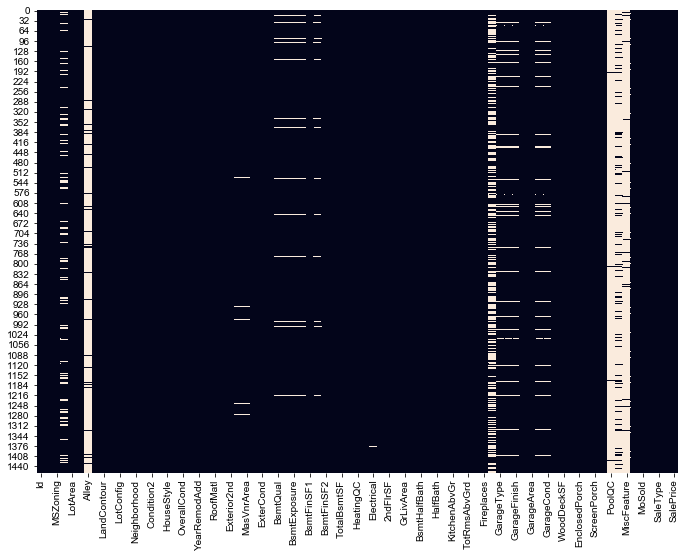

In [0]:
#### missing values
fig, ax = plt.subplots(figsize=(11.5,8.5))
sns.set_style("white")
sns.heatmap(train_df.isnull(), cbar=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000281ED72EA08>,
      dtype=object)

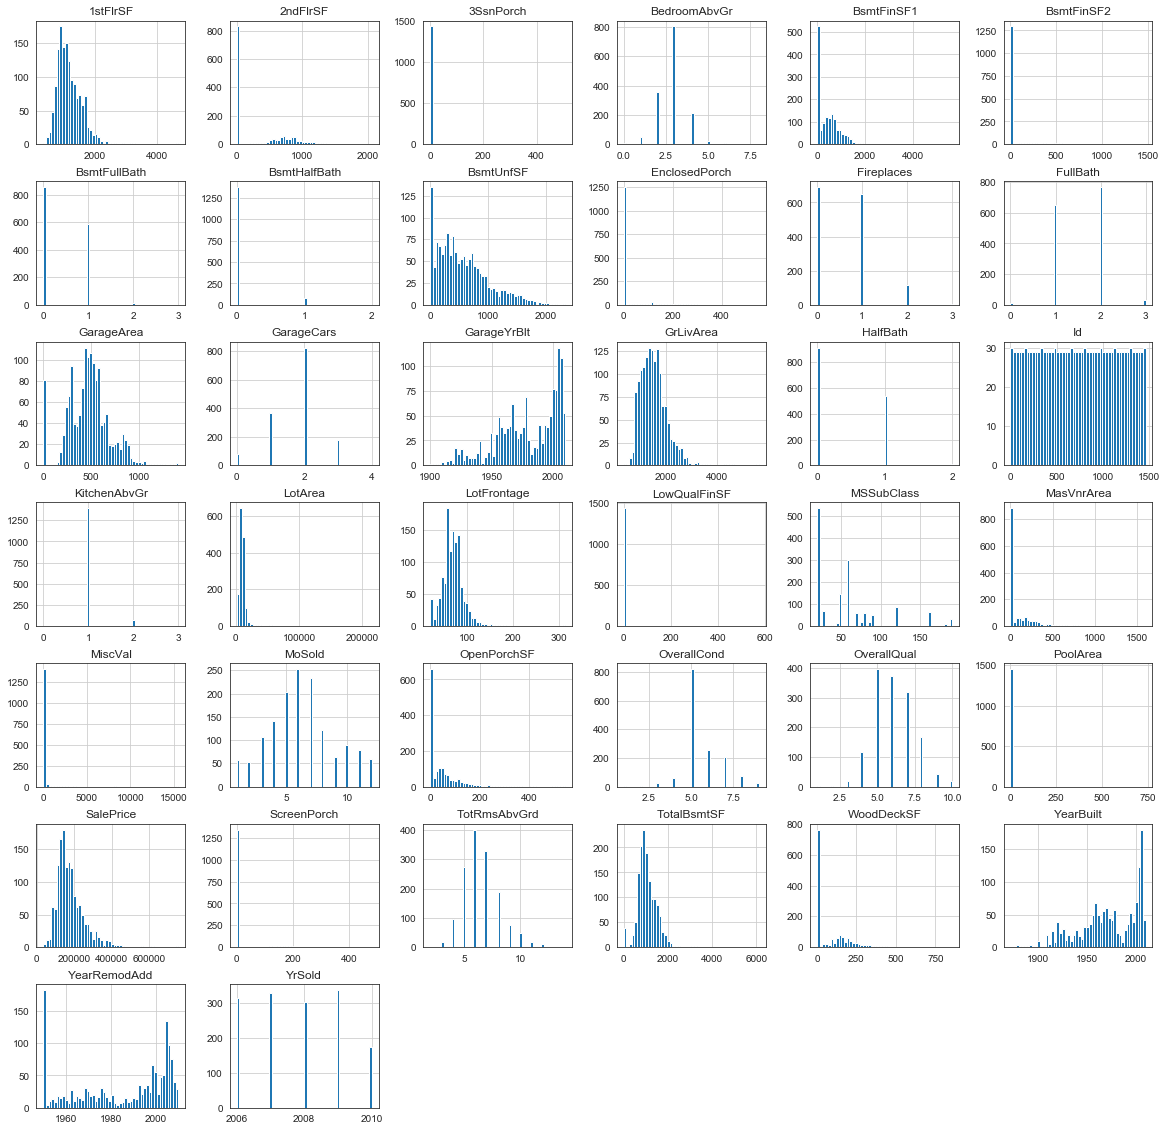

In [0]:
### Check the distribution of all the numeric variables
train_df.hist(bins=50, figsize=(20,20))

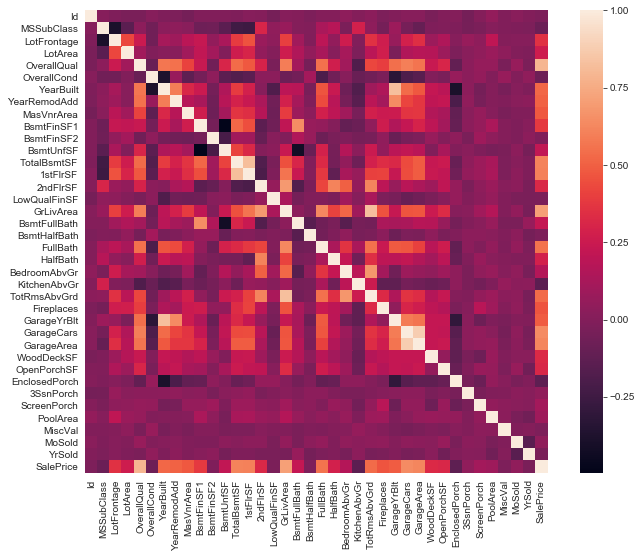

In [0]:
#### look at the correlation heatmap
fig, ax = plt.subplots(figsize=(11.5,8.5))
sns.set_style("white")
sns.heatmap(train_df.corr(),square=True)

,SalePrice
count,15.000000
mean,166387.389108
std,57697.237310
min,71000.000000
25%,128403.863636
50%,162990.000000
75%,204152.950485
max,262000.000000


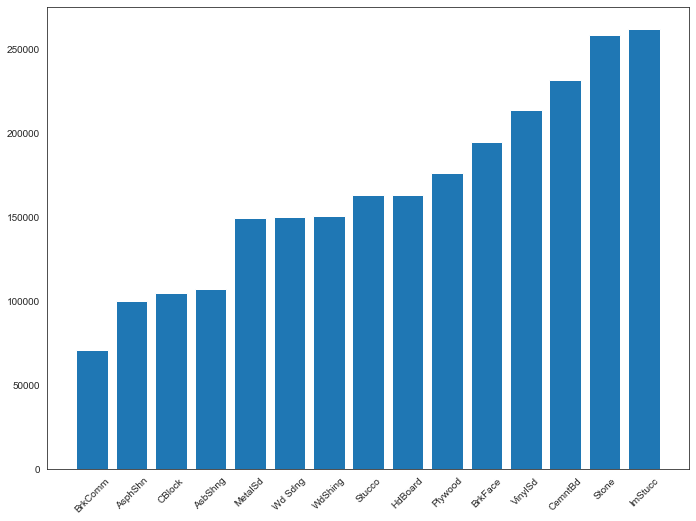

In [0]:
fig, ax = plt.subplots(figsize=(11.5,8.5))
a=train_full.groupby(['Exterior1st']).agg({'SalePrice':'mean'}).reset_index()
a.sort_values(by=['SalePrice'],inplace=True)
plt.xticks(rotation=45)
plt.bar(a['Exterior1st'],a['SalePrice'])
# b.set_xticklabels(b.get_xticklabels(),rotation=45)
a.describe()

,SalePrice
count,16.000000
mean,175288.201376
std,55551.545319
min,105000.000000
25%,145789.549492
50%,159776.873684
75%,200471.615079
max,319000.000000


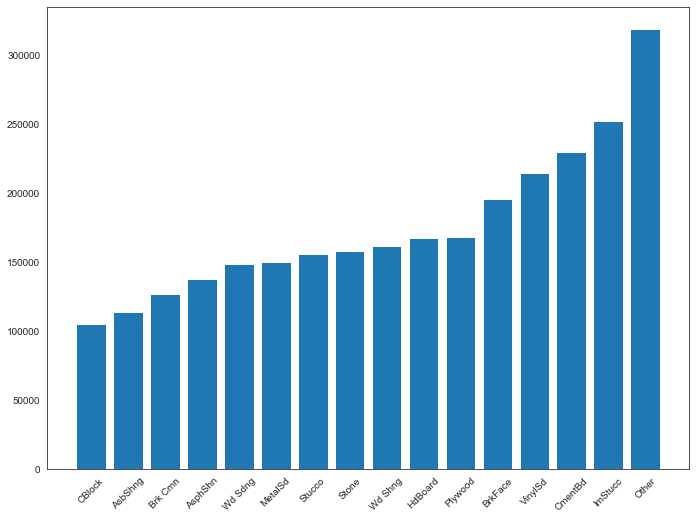

In [0]:
fig, ax = plt.subplots(figsize=(11.5,8.5))
a=train_full.groupby(['Exterior2nd']).agg({'SalePrice':'mean'}).reset_index()
a.sort_values(by=['SalePrice'],inplace=True)
plt.xticks(rotation=45)
plt.bar(a['Exterior2nd'],a['SalePrice'])
# b.set_xticklabels(b.get_xticklabels(),rotation=45)
a.describe()

,Functional,SalePrice
count,5.000000,5.000000
mean,3.000000,152420.094135
std,1.581139,22834.012465
min,1.000000,129000.000000
25%,2.000000,136014.421053
50%,3.000000,145263.569231
75%,4.000000,168393.333333
max,5.000000,183429.147059


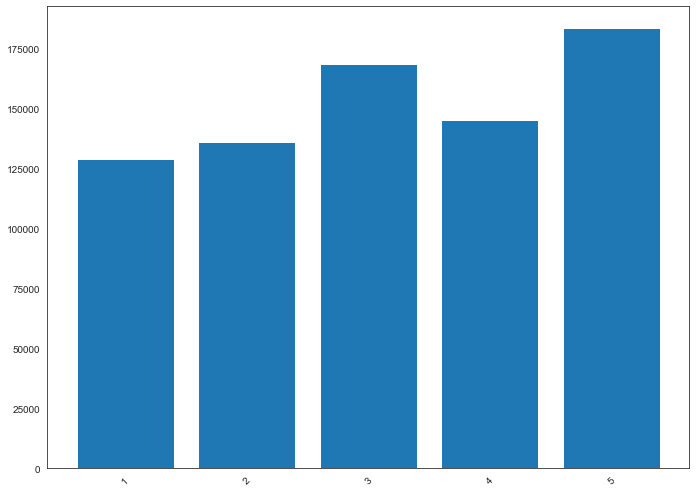

In [0]:
fig, ax = plt.subplots(figsize=(11.5,8.5))
a=train_full1.groupby(['Functional']).agg({'SalePrice':'mean'}).reset_index()
a.sort_values(by=['SalePrice'],inplace=True)
plt.xticks(rotation=45)
plt.bar(a['Functional'],a['SalePrice'])
# b.set_xticklabels(b.get_xticklabels(),rotation=45)
a.describe()

In [0]:
### Variables to drop
#train_full1.drop(['HouseStyle', 'MSSubClass', 'YearBuilt', 'YearRemodAdd', 'OpenPorchSF', 'EnclosedPorch', 'X3SsnPorch', 'ScreenPorch', 'Condition2'], axis=1)


In [0]:
#### Add New Variables
interest_df = interest_df.iloc[18812:20638]
interest_df.head()
interest_df.date = pd.to_datetime(interest_df.date)
interest_df[['year','month','day']] = interest_df.date.apply(lambda x: pd.Series(x.strftime("%Y,%m,%d").split(",")))
interest_df.drop(['day'], axis = 1, inplace = True)
interest_df = interest_df.reset_index(drop=True)
interest_df['yymm'] = interest_df.apply(lambda x: str(x['year']) + '-' + str(x['month']), axis = 1)
interest_rates = interest_df.groupby(['yymm']).mean()
interest_rates = interest_rates.reset_index()
interest_rates[['year','month']] = interest_rates['yymm'].apply(lambda x: pd.Series(x.split('-')))
interest_rates.drop(['yymm'], axis = 1, inplace = True)
interest_rates['month'] = interest_rates['month'].apply(lambda x: int(x))
interest_rates['year'] = interest_rates['year'].apply(lambda x: int(x))
interest_rates.rename(columns={" value": "Interest", "year": "YrSold", "month": 'MoSold'}, inplace = True)
interest_rates.head()

train_full1 = pd.merge(train_full1, interest_rates,  how='left', left_on=['YrSold','MoSold'], right_on = ['YrSold','MoSold'])

In [0]:
train_full1.head(10)

,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,OverallQual,OverallCond,RoofStyle,RoofMatl,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,PavedDrive,WoodDeckSF,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Pool,GarageQuality,HouseAge,GarageAge,Remodel,TotalBath,WeightTotalBsmtSF,TotalPorchSF,Condition2Renew,PUD,SFoyer,Floor,Finish,Slvl,ExteriorBin,Interest
0,3,65.0,8450,Pave,3,Lvl,AllPub,Inside,0,CollgCr,Norm,1Fam,7,5,Gable,CompShg,BrkFace,196.0,4,3,PConc,4,3,1,6,706,1,0,150,856,GasA,5,1,SBrkr,856,854,0,1710,3,1,4,8,5,0,0,Attchd,2,2,548,Y,0,0,0,None,None,0,2,2008,WD,Normal,208500,0,3.0,5,5.0,1,3.5,4386,61,0,0,0,2.0,1,0,1.00,2.980690
1,3,80.0,9600,Pave,3,Lvl,AllPub,FR2,0,Veenker,Feedr,1Fam,6,8,Gable,CompShg,None,0.0,3,3,CBlock,4,3,4,5,978,1,0,284,1262,GasA,5,1,SBrkr,1262,0,0,1262,3,1,3,6,5,1,3,Attchd,2,2,460,Y,298,0,0,None,None,0,5,2007,WD,Normal,181500,0,3.0,31,31.0,1,2.5,5174,0,1,0,0,1.0,1,0,0.50,5.253548
2,3,68.0,11250,Pave,2,Lvl,AllPub,Inside,0,CollgCr,Norm,1Fam,7,5,Gable,CompShg,BrkFace,162.0,4,3,PConc,4,3,2,6,486,1,0,434,920,GasA,5,1,SBrkr,920,866,0,1786,3,1,4,6,5,1,3,Attchd,2,2,608,Y,0,0,0,None,None,0,9,2008,WD,Normal,223500,0,3.0,6,7.0,1,3.5,3350,42,0,0,0,2.0,1,0,1.00,1.811667
3,3,60.0,9550,Pave,2,Lvl,AllPub,Corner,0,Crawfor,Norm,1Fam,7,5,Gable,CompShg,None,0.0,3,3,BrkTil,3,4,1,5,216,1,0,540,756,GasA,4,1,SBrkr,961,756,0,1717,3,1,4,7,5,1,4,Detchd,1,3,642,Y,0,0,0,None,None,0,2,2006,WD,Abnorml,140000,0,3.0,36,8.0,1,2.0,1620,307,0,0,0,2.0,1,0,0.50,4.491429
4,3,84.0,14260,Pave,2,Lvl,AllPub,FR2,0,NoRidge,Norm,1Fam,8,5,Gable,CompShg,BrkFace,350.0,4,3,PConc,4,3,3,6,655,1,0,490,1145,GasA,5,1,SBrkr,1145,1053,0,2198,4,1,4,9,5,1,3,Attchd,2,3,836,Y,192,0,0,None,None,0,12,2008,WD,Normal,250000,0,3.0,8,8.0,1,3.5,4420,84,0,0,0,2.0,1,0,1.00,0.155161
5,3,85.0,14115,Pave,2,Lvl,AllPub,Inside,0,Mitchel,Norm,1Fam,5,5,Gable,CompShg,None,0.0,3,3,Wood,4,3,1,6,732,1,0,64,796,GasA,5,1,SBrkr,796,566,0,1362,1,1,3,5,5,0,0,Attchd,1,2,480,Y,40,0,0,MnPrv,Shed,700,10,2009,WD,Normal,143000,0,3.0,14,16.0,1,2.5,4456,350,0,0,0,1.5,1,0,1.00,0.118065
6,3,75.0,10084,Pave,3,Lvl,AllPub,Inside,0,Somerst,Norm,1Fam,8,5,Gable,CompShg,Stone,186.0,4,3,PConc,5,3,3,6,1369,1,0,317,1686,GasA,5,1,SBrkr,1694,0,0,1694,3,1,4,7,5,1,4,Attchd,2,2,636,Y,255,0,0,None,None,0,8,2007,WD,Normal,307000,0,3.0,2,3.0,1,3.0,8531,57,0,0,0,1.0,1,0,1.00,5.022258
7,3,0.0,10382,Pave,2,Lvl,AllPub,Corner,0,NWAmes,PosN,1Fam,7,6,Gable,CompShg,Stone,240.0,3,3,CBlock,4,3,2,5,859,4,32,216,1107,GasA,5,1,SBrkr,1107,983,0,2090,3,1,3,7,5,2,3,Attchd,2,2,484,Y,235,0,0,None,Shed,350,11,2009,WD,Normal,200000,0,3.0,36,36.0,1,3.5,4423,432,1,0,0,2.0,1,0,0.75,0.119000
8,1,51.0,6120,Pave,3,Lvl,AllPub,Inside,0,OldTown,Artery,1Fam,7,5,Gable,CompShg,None,0.0,3,3,BrkTil,3,3,1,1,0,1,0,952,952,GasA,4,1,FuseF,1022,752,0,1774,2,2,3,8,4,2,3,Detchd,1,2,468,Y,90,0,0,None,None,0,4,2008,WD,Abnorml,129900,0,2.5,58,77.0,1,2.0,952,205,1,0,0,1.5,1,0,0.75,2.278333
9,3,50.0,7420,Pave,3,Lvl,AllPub,Corner,0,BrkSide,Artery,2fmCon,5,6,Gable,CompShg,None,0.0,3,3,BrkTil,3,3,1,6,851,1,0,140,991,GasA,5,1,SBrkr,1077,0,0,1077,2,2,3,5,5,2,3,Attchd,2,1,205,Y,0,0,0,None,None,0,1,2008,WD,Normal,118000,0,3.5,58,69.0,1,2.0,5246,4,0,0,0,1.5,0,0,0.50,3.940323


In [0]:
def Qrtr(x):
  for i in x['MoSold']:
      return (i+2)//3

In [0]:
ameshpi['Qrtr'] = ameshpi['MoSold'].apply(lambda i : (i+2)//3)

In [0]:
train_full1['Qrtr'] = train_full['MoSold'].apply(lambda i:(i+2)//3)
del ameshpi['MoSold']

In [0]:
train_full1 = pd.merge(train_full1, ameshpi,  how='left', on=['YrSold','Qrtr'])

In [0]:
train_full1['SalePriceAd'] = (train_full1['SalePrice']/(train_full1['ATNHPIUS11180Q']/100))

In [0]:
train_full1[['SalePrice','SalePriceAd','YrSold']].head(10)

,SalePrice,SalePriceAd,YrSold
0,208500,123285.241249,2008
1,181500,108029.283971,2007
2,223500,134444.177093,2008
3,140000,86053.230069,2006
4,250000,149781.319274,2008
5,143000,85597.988747,2009
6,307000,183645.390919,2007
7,200000,119717.466778,2009
8,129900,77840.364334,2008
9,118000,69772.942289,2008


**School Ranking**

In [0]:
sch_rank1 = sch_rank.loc[((sch_rank['District'] == 'Ames Community School District') | (sch_rank['District']== 'Gilbert Community School District')) & (sch_rank['SchoolType'] == 'Elementary')]

sch_rank1['School_Name'].value_counts()

sch_rank2 = sch_rank1[['District', 'School_Name', 'Rank']]

def schPlace(x):
  if x['School_Name'] == 'Edwards Elementary School':
    return 'Edwards'
  elif x['School_Name'] == 'Gilbert Elementary School':
    return 'Gilbert'
  elif x['School_Name'] == 'Sawyer Elementary School':
    return 'Sawyer'
  elif x['School_Name'] == 'Fellows Elementary School':
    return 'NAmes'
  elif x['School_Name'] == 'Meeker Elementary School':
    return 'NWAmes'
  elif x['School_Name'] == 'Gilbert Intermediate School':
    return 'Gilbert'
  elif x['School_Name'] == 'Mitchell Elementary School':
    return 'Mitchel'
  elif x['School_Name'] == 'Northwood Pre-School':
    return 'NWAmes'

In [0]:
sch_rank2['Neighborhood'] = sch_rank2.apply (lambda row: schPlace(row), axis=1)
sch_rank2

c:\users\limwe\anaconda3\envs\tensorflow_gpupip\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,District,School_Name,Rank,Neighborhood
9,Ames Community School District,Edwards Elementary School,Commendable,Edwards
14,Ames Community School District,Fellows Elementary School,Commendable,NAmes
15,Ames Community School District,Mitchell Elementary School,Commendable,Mitchel
40,Ames Community School District,Sawyer Elementary School,Commendable,Sawyer
580,Gilbert Community School District,Gilbert Intermediate School,Unable to Rate,Gilbert
1146,Ames Community School District,Meeker Elementary School,Acceptable,NWAmes
1215,Gilbert Community School District,Gilbert Elementary School,Unable to Rate,Gilbert
1336,Ames Community School District,Edwards Elementary School,Commendable,Edwards
1399,Ames Community School District,Meeker Elementary School,High-Performing,NWAmes
1408,Ames Community School District,Fellows Elementary School,High-Performing,NAmes


In [0]:
SchReplace = {
   'Rank': {
      'Unable to Rate': 0, 'Acceptable': 1, 'Commendable': 2, 'High-Performing': 3
   }
}
sch_rank2.replace(SchReplace, inplace=True)

c:\users\limwe\anaconda3\envs\tensorflow_gpupip\lib\site-packages\pandas\core\generic.py:6704: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regex=regex,


In [0]:
sch_rank3 = sch_rank2.groupby('Neighborhood').agg({'Rank':'mean'})
sch_rank3

,Rank
Neighborhood,
Edwards,2.000000
Gilbert,1.000000
Mitchel,2.333333
NAmes,2.666667
NWAmes,1.500000
Sawyer,2.333333


In [0]:
sch_rank3
train_full2 = pd.merge(train_full1, sch_rank3, on='Neighborhood', how='left')
train_full2['Rank'].fillna(train_full2['Rank'].mean(), inplace=True)


In [0]:
# from google.colab import files
# train_full2.to_csv('train_schrank.csv')
# files.download('train_schrank.csv')

NameError: ignored

# **Normalization**

In [0]:
# numTrain = train_full2.loc[:, train_full2.dtypes != 'object'].index #from above
numTrainidx = train_full2.dtypes[train_full2.dtypes != "object"].index
numTrainidx

# Check how skewed they are
numTrainskew = train_full2[numTrainidx].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
numTrainskew
# plt.subplots(figsize =(65, 20))
# numTrainskew.plot(kind='bar');

MiscVal              24.451640
PoolQC               15.942166
PoolArea             14.813135
Pool                 14.337930
LotArea              12.195142
LowQualFinSF          9.002080
SFoyer                6.040320
LandSlope             4.808735
KitchenAbvGr          4.483784
BsmtFinSF2            4.250888
BsmtFinType2          3.293608
MasVnrArea            2.674865
PUD                   2.499615
WeightTotalBsmtSF     2.457457
Condition2Renew       2.154375
TotalPorchSF          1.997973
SalePriceAd           1.894341
SalePrice             1.880941
BsmtFinSF1            1.683771
WoodDeckSF            1.539792
TotalBsmtSF           1.522688
ExterCond             1.395783
1stFlrSF              1.375342
GrLivArea             1.365156
BsmtExposure          1.101835
BsmtUnfSF             0.919323
ExterQual             0.825140
2ndFlrSF              0.812194
OverallCond           0.692355
GarageAge             0.688871
TotRmsAbvGrd          0.675646
Fireplaces            0.648898
HouseAge

In [0]:
skewness = numTrainskew[abs(numTrainskew) > 0.5]

numTrainskew2 = skewness.index
numTrainskew2
lam = 0.15
train_full15 = train_full2.copy()
for feat in numTrainskew2:
    train_full2[feat] = boxcox1p(train_full2[feat], lam)

print(skewness.shape[0],  "skewed numerical features have been Box-Cox transformed")

# skewness = skewed_feats[abs(skewed_feats) > 0.5]

# skewed_features = skewness.index
# lam = 0.15
# for feat in skewed_features:
#     all_data[feat] = boxcox1p(all_data[feat], lam)

# print(skewness.shape[0],  "skewed numerical features have been Box-Cox transformed")

44 skewed numerical features have been Box-Cox transformed


In [0]:
# numTrain = train_full2.loc[:, train_full2.dtypes != 'object'].index #from above
numTrainidx = train_full2.dtypes[train_full2.dtypes != "object"].index
numTrainidx

# Check how skewed they are
numTrainskew = train_full2[numTrainidx].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
numTrainskew
# plt.subplots(figsize =(65, 20))
# numTrainskew.plot(kind='bar');

PoolQC               15.070508
PoolArea             14.363418
Pool                 14.337930
LowQualFinSF          7.593301
SFoyer                6.040320
MiscVal               5.505530
LandSlope             4.345857
KitchenAbvGr          3.995746
BsmtFinSF2            2.619350
PUD                   2.499615
Condition2Renew       2.154375
BsmtFinType2          2.149534
LotArea               0.751948
BsmtExposure          0.679184
MasVnrArea            0.604240
ExterQual             0.601210
ExterCond             0.540146
Floor                 0.457879
KitchenQual           0.386368
SalePriceAd           0.369201
SalePrice             0.368049
2ndFlrSF              0.310478
LotFrontage           0.267547
TotalBath             0.264404
1stFlrSF              0.234374
Fireplaces            0.230377
OverallQual           0.216721
WoodDeckSF            0.216523
MoSold                0.211835
BedroomAbvGr          0.211572
GarageArea            0.179796
Qrtr                  0.175235
GrLivAre

In [0]:
train_full15.hist(bins=50, figsize = (20,20))

In [0]:
from google.colab import files
# train_full2.to_csv('train_schrank.csv')
# files.download('train_schrank.csv')